In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importing Libraries

In [ ]:
import mlflow
from tensorboardX import SummaryWriter
import tensorflow as tf
import tensorflow.summary
from tensorflow.summary import scalar
from tensorflow.summary import histogram
import mlflow.pytorch
import seaborn as sns
from datetime import date
today = str(date.today())

In [ ]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.0+cu118
Torchvision Version:  0.15.1+cu118


In [ ]:
# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        
        # Encoder network
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim*2)
        )
        
        # Decoder network
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )
        
        # Latent dimension
        self.latent_dim = latent_dim

    def encode(self, x):
        # Encode input to mean and variance
        h = self.encoder(x)
        mu, log_var = torch.split(h, self.latent_dim, dim=1)
        return mu, log_var
    
    def decode(self, z):
        # Decode latent variable to output
        x = self.decoder(z)
        return x
    
    def reparameterize(self, mu, log_var):
        # Reparameterize the distribution
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        z = mu + eps*std
        return z
    
    def forward(self, x):
        # Forward pass through the network
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return x_recon, mu, log_var

vae = VAE()

TypeError: ignored

#Data Pipeline

In [ ]:
data_dir = '/content/drive/MyDrive/Datasets/Screw Dataset/archive/'

# Models to choose from [resnet, alexnet, vgg16, squeezenet, densenet, inception]
model_name = "alexnet"
num_classes = 2
batch_size = 32
num_epochs = 20
feature_extract = False
pre_trained=True

save_model='/content/drive/MyDrive/Datasets/'
save_confusion_mat='/content/drive/MyDrive/Datasets/densenet_17_mat.csv'

In [ ]:
def log_scalar(name, value, step):
    """Log a scalar value to both MLflow and TensorBoard"""
    mlflow.log_metric(name, value, step=step)

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()
    test_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)


                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):

                    if is_inception and phase == 'train':
                        
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            if phase=='train':
                log_scalar('training_loss', epoch_loss, epoch)
                log_scalar('training_accuracy', float(epoch_acc), epoch)
            if phase=='test':
                log_scalar('test_loss', epoch_loss, epoch)
                log_scalar('test_accuracy', float(epoch_acc), epoch)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'test':
                test_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    mlflow.log_param('Training time',time_elapsed)
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))
    mlflow.log_param('Best test Acc',float(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, test_acc_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):

    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg16":
        """ VGG16_bn
        """
        model_ft = models.vgg16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet201
        """
        model_ft = models.densenet201(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)

        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)

        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=pre_trained)

# Print the model we just instantiated
print(model_ft)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Data augmentation and normalization for training

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}

dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


# Observing that all parameters are being optimized

In [ ]:
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.3.weight
	 features.3.bias
	 features.6.weight
	 features.6.bias
	 features.8.weight
	 features.8.bias
	 features.10.weight
	 features.10.bias
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.6.weight
	 classifier.6.bias


In [ ]:
with mlflow.start_run() as run:
    mlflow.log_param('dataset', data_dir)
    mlflow.log_param('model name', model_name)
    mlflow.log_param('number of classes', num_classes)
    mlflow.log_param('Batch size', batch_size)
    mlflow.log_param('epochs', num_epochs)
    mlflow.log_param('feature extracted', feature_extract)
    mlflow.log_param('pre-trained', pre_trained)
    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()

    # Train and evaluate
    model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))
    mlflow.pytorch.log_model(model_ft,"models")
    mlflow.pytorch.save_model(model_ft,save_model+today+'/')

Epoch 0/19
----------
train Loss: 0.5456 Acc: 0.7867
test Loss: 0.5952 Acc: 0.6500

Epoch 1/19
----------
train Loss: 0.5219 Acc: 0.8167
test Loss: 0.8630 Acc: 0.3833

Epoch 2/19
----------
train Loss: 0.5406 Acc: 0.8033
test Loss: 0.4368 Acc: 0.8333

Epoch 3/19
----------
train Loss: 0.4663 Acc: 0.8100
test Loss: 0.4148 Acc: 0.8333

Epoch 4/19
----------
train Loss: 0.4418 Acc: 0.8333
test Loss: 0.3983 Acc: 0.8333

Epoch 5/19
----------
train Loss: 0.4270 Acc: 0.8267
test Loss: 0.3683 Acc: 0.8333

Epoch 6/19
----------
train Loss: 0.4235 Acc: 0.8333
test Loss: 0.3652 Acc: 0.8500

Epoch 7/19
----------
train Loss: 0.4138 Acc: 0.8467
test Loss: 0.3546 Acc: 0.8500

Epoch 8/19
----------
train Loss: 0.4313 Acc: 0.8267
test Loss: 0.3377 Acc: 0.9000

Epoch 9/19
----------
train Loss: 0.4468 Acc: 0.8333
test Loss: 0.4099 Acc: 0.8833

Epoch 10/19
----------
train Loss: 0.4215 Acc: 0.8367
test Loss: 0.3482 Acc: 0.8333

Epoch 11/19
----------
train Loss: 0.4343 Acc: 0.8333
test Loss: 0.3805 Acc

2023/04/02 19:43:31 WARNING mlflow.utils.requirements_utils: Found torch version (1.13.1+cu116) contains a local version label (+cu116). MLflow logged a pip requirement for this package as 'torch==1.13.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/04/02 19:43:35 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.14.1+cu116) contains a local version label (+cu116). MLflow logged a pip requirement for this package as 'torchvision==0.14.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/04/02 19:43:37 WARNING mlflow.utils.requirements_utils: Found torch version (1.13.1+cu116) contains a local version label (+cu116). MLflow logged a pip requirement for this package as 'torch==1.13.1' without the local version l

#Confusion Matrix Pipeline

In [ ]:
confusion_matrix = torch.zeros(num_classes, num_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

In [ ]:
import pandas as pd

classes=["good","not-good"]
df_cm = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in classes],
                  columns = [i for i in classes])

In [ ]:
df_cm=df_cm.astype(np.int64)

In [ ]:
df_cm.to_csv(save_confusion_mat)

<Axes: >

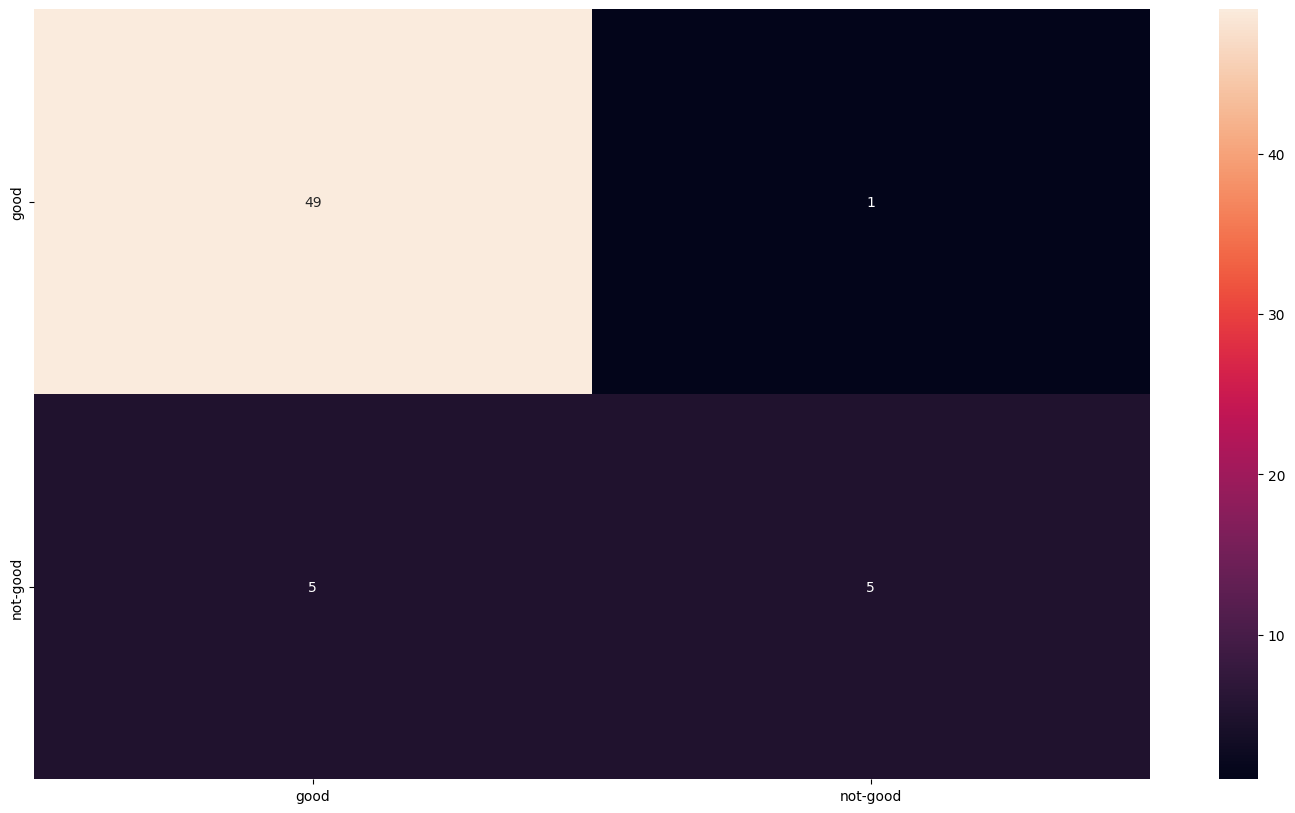

In [ ]:
# plt.figure(figsize = (16,8)) 
f, ax = plt.subplots(figsize=(18, 10))
sns.heatmap(df_cm,annot=True, fmt="d")